In [1]:
%matplotlib widget
import numpy as np
import cmath
import matplotlib.pyplot as plt
import os
print(os.getpid())
%cd ../

import pylib.mix as mix
import pylib.Chebyschev_coefs as ch

3597
/media/work/docs/codes/QuCF/scripts-py


In [2]:
for i in range(30):
    plt.close()

In [3]:
# ---------------------------------------------------
# --- Choose the function to approximate ---
# ---------------------------------------------------
mix.reload_module(ch)

# --- Choose the computational method ---
sel_method = 0

# --- Choose the function to approximate ---
id_fun = 1 # chosen function;
par1   = 60 # function parameter;

# id_fun = 4 # chosen function;
# par1   = 20 # function parameter;

# --- Choose the polynomial degree ---
# Nd = int(8000/80. * 60.)  # for inversion
# Nd = int(900/40. * 5) 
# Nd = int(300/5. * 10) 
# Nd = 400

# --- Computation ---
oo_ch_ = ch.Ch_()
oo_ch_.choose_method(sel_method)
oo_ch_.choose_func(id_fun, par1)
oo_ch_.compute_Ch(Nd)
oo_ch_.plot_reconstructed_function()

Function parameter:		 6.000e+01
Chosen function, parity:	 inv, 1

Minimization method is used.


/media/work/docs/codes/QuCF/scripts-py/env/lib/python3.11/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/media/work/docs/codes/QuCF/scripts-py/env/lib/python3.11/site-packages/cvxpy/problems/problem.py:164: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


<IPython.core.display.Javascript object>


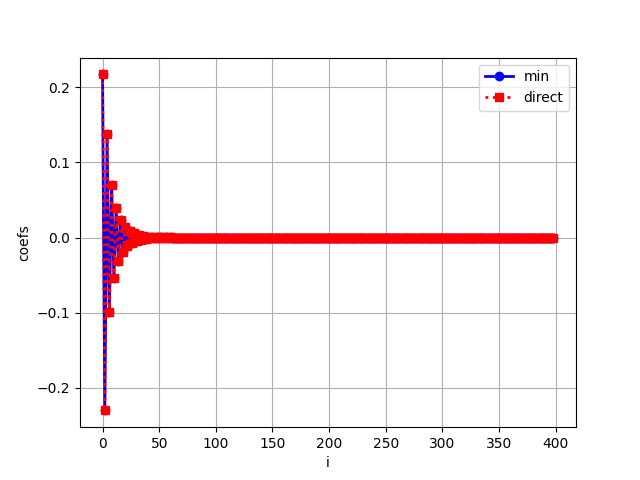

In [5]:
# ----------------------------------------------------
# --- Plot Chebyschev coefficients ---
# ----------------------------------------------------
oo_ch_.plot_coefficients()

In [17]:
# -----------------------------------------------------------------
# --- Store the coefficients into the .hdf5 file ---
# -----------------------------------------------------------------
oo_ch_.save_coefficients()

write angles to:
 ./tools/QSVT-angles/LCHS-weights/coefs//LCHS-weights_10_2.hdf5
